In [ ]:
import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import  Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from tensorflow.keras.preprocessing import image

In [ ]:
IMAGE_W = 224
IMAGE_H = 224

In [ ]:

def get_model():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

    # Dong bang cac layer
    for layer in model_vgg16_conv.layers:
        layer.trainable = False

    # Tao model
    input = Input(shape=(IMAGE_W, IMAGE_H, 3), name='image_input')
    output_vgg16_conv = model_vgg16_conv(input)

    # Them cac layer FC va Dropout
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(5, activation='sigmoid', name='predictions')(x)

    # Compile
    my_model = Model(inputs=input, outputs=x)
    my_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['BinaryAccuracy'])

    return my_model

model = get_model()

In [ ]:
csv_file = "/content/drive/MyDrive/data/phongcanh/miml_dataset/miml_labels_1.csv"
image_path ="/content/drive/MyDrive/data/phongcanh/miml_dataset/images"

train = pd.read_csv(csv_file)
train.head

<bound method NDFrame.head of      Filenames  desert  mountains  sea  sunset  trees
0        1.jpg       1          0    0       0      0
1        2.jpg       1          0    0       0      0
2        3.jpg       1          0    0       0      0
3        4.jpg       1          1    0       0      0
4        5.jpg       1          0    0       0      0
...        ...     ...        ...  ...     ...    ...
1995  1996.jpg       0          0    0       0      1
1996  1997.jpg       0          0    0       0      1
1997  1998.jpg       0          0    0       0      1
1998  1999.jpg       0          0    0       0      1
1999  2000.jpg       0          0    0       0      1

[2000 rows x 6 columns]>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load data
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.size = size

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)

    def __len__(self):
        return self.size // self.batch_size

class Dataset:
    def __init__(self, data, label, w, h):
        # the paths of images
        self.data = data
        # the paths of segmentation images
        self.label = label
        self.w = w
        self.h = h

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        # read data
        img = image.load_img(image_path + '/' + str(self.data[i][0]),target_size=(IMAGE_W,IMAGE_H,3))
        img = image.img_to_array(img)
        img = img /255
        label = self.label[i]
        return img, label


In [ ]:
y = np.array(train.drop(columns=["Filenames"]))
X = np.array(train)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [ ]:
# Xay dung dataset va Dataloader
# Build dataaset
train_dataset = Dataset(X_train, y_train, IMAGE_W, IMAGE_H)
test_dataset = Dataset(X_test, y_test, IMAGE_W, IMAGE_H)

# Loader

train_loader = Dataloader(train_dataset, 64, len(train_dataset))
test_loader = Dataloader(test_dataset, 64, len(test_dataset))


In [ ]:
model.fit_generator(train_loader, epochs=10, validation_data=test_loader)
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
28/28 [==============================] - 13s 416ms/step - loss: 1.3581 - binary_accuracy: 0.7444 - val_loss: 0.3470 - val_binary_accuracy: 0.8417
Epoch 2/10
28/28 [==============================] - 11s 389ms/step - loss: 0.3357 - binary_accuracy: 0.8539 - val_loss: 0.2780 - val_binary_accuracy: 0.8885
Epoch 3/10
28/28 [==============================] - 11s 391ms/step - loss: 0.2636 - binary_accuracy: 0.8894 - val_loss: 0.2675 - val_binary_accuracy: 0.8927
Epoch 4/10
28/28 [==============================] - 11s 400ms/step - loss: 0.2157 - binary_accuracy: 0.9116 - val_loss: 0.2428 - val_binary_accuracy: 0.9042
Epoch 5/10
28/28 [==============================] - 12s 408ms/step - loss: 0.1870 - binary_accuracy: 0.9241 - val_loss: 0.2647 - val_binary_accuracy: 0.8927
Epoch 6/10
28/28 [==============================] - 12s 407ms/step - loss: 0.1716 - binary_accuracy: 0.9309 - val_loss: 0.2614 - val_binary_accuracy: 0.8969
Epoch 7/10
28/28 [==============================] - 12s 41

In [ ]:
img = image.load_img("/content/drive/MyDrive/data/phongcanh/miml_dataset/images/55.jpg", target_size=(IMAGE_W,IMAGE_H,3))
img = image.img_to_array(img)
img = img/255

tensor = np.expand_dims(img, axis=0)

In [ ]:
y_pred = model.predict(tensor)
y_pred

array([[9.9997067e-01, 2.3527606e-03, 4.3246804e-05, 3.2471094e-04,
        1.5914631e-03]], dtype=float32)

In [ ]:
classes = np.array(train.columns[1:])

top_3 = np.argsort(y_pred[0])[:-4:-1]
top_3

array([0, 1, 4])

desert (1.0)
mountains (0.00235)
trees (0.00159)


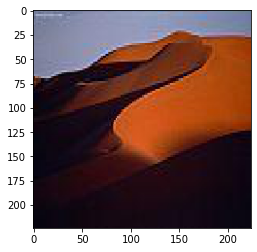

In [ ]:
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(y_pred[0][top_3[i]]))
plt.imshow(img)